In [223]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import train
from random import shuffle
import imp
%matplotlib inline

In [307]:
imp.reload(train)

## Training in the notebook
# X_train, X_test, y_train, y_test = train.get_dataset()
# model, opt = train.create_model(X_train.shape[1:])
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model, history = train.training(model, X_train, X_test, y_train, y_test, data_augmentation=True)

## Training on AWS
X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('model.h5')
# with open('./history.pkl', 'rb') as f:
#     history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (5649, 64, 64, 3) (5649, 8)
Test (628, 64, 64, 3) (628, 8)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.94      0.94        35
            bart_simpson       1.00      0.86      0.92        90
charles_montgomery_burns       0.98      0.94      0.96        48
           homer_simpson       0.96      0.97      0.96       151
        krusty_the_clown       0.95      1.00      0.98        40
            lisa_simpson       0.90      0.98      0.94        99
           marge_simpson       0.98      1.00      0.99       113
             moe_szyslak       0.98      1.00      0.99        52

             avg / total       0.96      0.96      0.96       628



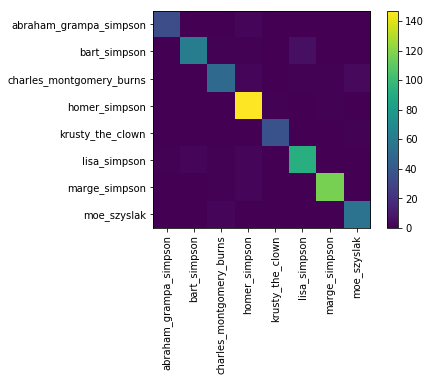

In [294]:
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [340]:
import urllib
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict_proba(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

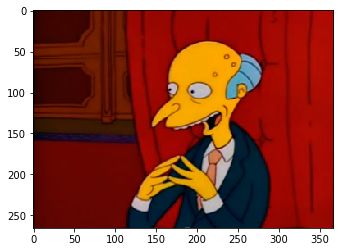

1/1 [==============================] - 0s


'Charles Montgomery Burns'

In [345]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
plot_and_predict(url)